In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

## Calculated PSF from PROPER

In [2]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)
beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'opd_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }
gridsize = 2048 # sampling of wavefront
wavelength = 0.65 # micros

def get_source(dx, dy, dI):
    settings = toliman_settings.copy()
    settings['tilt_x'] = dx
    settings['tilt_y'] =dy
    new  = {
            'wavelengths': [wavelength],
            'weights': [dI],
            'settings': settings
            }
    return new

In [3]:
import proper
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

# Calculated PSF
# First source, on axis
# Second source, offset 5" and fainter
from proper_tools import form_detector_image
raw_image = form_detector_image('prescription_rc_quad', [get_source(0,0,1.), get_source(0,5.,1./3.)], gridsize, detector_pitch, npixels)#,multi=False)


/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


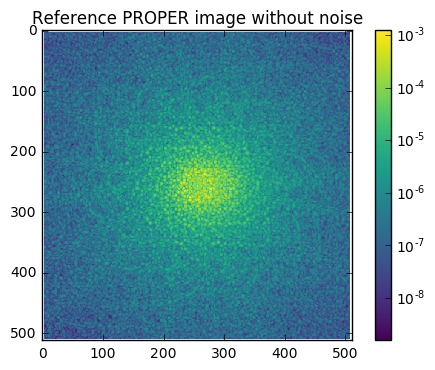

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(raw_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image without noise')
plt.show()

## Add Poisson noise

Scale image to have a peak of 25k to be below saturation, then add photon noise by drawing random values from a Poisson distribution.

In [5]:
intensity_scale = (25000/raw_image.max(axis=None))
detector_image = np.random.poisson(
    intensity_scale*np.clip(raw_image,0.,1.)
)

In [6]:
# Get lower bound on error
min_err = np.sum((detector_image - intensity_scale*raw_image)**2) 
print(min_err)

24623906.284


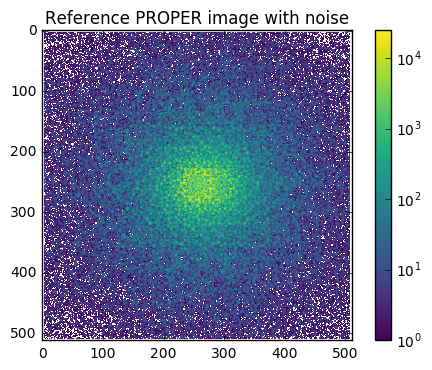

In [7]:
plt.imshow(detector_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image with noise')
plt.show()

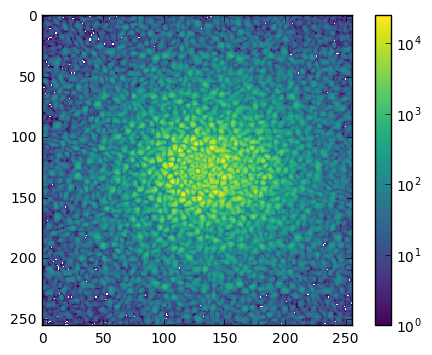

In [11]:
plt.imshow(detector_image[128:128*3,128:128*3], interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.show()

# Fit by tweaking position and flux


In [16]:
# Function to generate 
errors = []
def model_err(params, view=False):
    tiltx1 = params[0]
    tilty1 = params[1]
    flux1 = params[2]
    tiltx2 = params[3]
    tilty2 = params[4]
    flux2 = params[5]
    im = form_detector_image('prescription_rc_quad', [get_source(tiltx1,tiltx1,flux1), get_source(tiltx2,tiltx2,flux2)], gridsize, detector_pitch, npixels)
    # Adjust scale
    im *= intensity_scale#*flux
    if view:
        plt.imshow(im, interpolation = 'none', cmap='viridis',norm=LogNorm())
        plt.colorbar()
        plt.show()
    error = np.sum((im - detector_image)**2)
    errors.append((params,error))
    print('Error for offsets ({:.2e},{:.2e}),({:.2e},{:.2e}) and fluxes {:.2e},{:.2e}: {}% baseline '.format(tiltx1, tiltx1, tiltx2, tiltx2, flux1, flux2, round(100.*error/min_err)))
    return error

## Optimize

### Nelder-Mead Simplex algorithm

This is a popular derivative-free multivariate minimization algorithm.

In [17]:
from scipy.optimize import minimize
errors=[]
params_init = [0.1, 0.1, 0.8, -0.1, -0.1, 1.1]
opt = minimize(model_err, params_init, method='nelder-mead')

Error for offsets (1.00e-01,1.00e-01),(-1.00e-01,-1.00e-01) and fluxes 8.00e-01,1.10e+00: 159835.0% baseline 
Error for offsets (1.05e-01,1.05e-01),(-1.00e-01,-1.00e-01) and fluxes 8.00e-01,1.10e+00: 159712.0% baseline 
Error for offsets (1.00e-01,1.00e-01),(-1.00e-01,-1.00e-01) and fluxes 8.00e-01,1.10e+00: 159835.0% baseline 
Error for offsets (1.00e-01,1.00e-01),(-1.00e-01,-1.00e-01) and fluxes 8.40e-01,1.10e+00: 171003.0% baseline 
Error for offsets (1.00e-01,1.00e-01),(-1.05e-01,-1.05e-01) and fluxes 8.00e-01,1.10e+00: 162226.0% baseline 
Error for offsets (1.00e-01,1.00e-01),(-1.00e-01,-1.00e-01) and fluxes 8.00e-01,1.10e+00: 159835.0% baseline 
Error for offsets (1.00e-01,1.00e-01),(-1.00e-01,-1.00e-01) and fluxes 8.00e-01,1.16e+00: 179890.0% baseline 
Error for offsets (1.02e-01,1.02e-01),(-1.02e-01,-1.02e-01) and fluxes 8.13e-01,1.04e+00: 145600.0% baseline 
Error for offsets (1.02e-01,1.02e-01),(-1.02e-01,-1.02e-01) and fluxes 8.20e-01,9.90e-01: 130824.0% baseline 
Error for 

In [18]:
print(opt)

 final_simplex: (array([[  2.92036636e-01,  -2.42286373e-01,   7.47674457e-02,
          7.54148976e-04,  -4.51039022e-01,   1.05663940e+00],
       [  2.92036598e-01,  -2.42286207e-01,   7.47674281e-02,
          7.54151986e-04,  -4.51038999e-01,   1.05663942e+00],
       [  2.92036646e-01,  -2.42286400e-01,   7.47674076e-02,
          7.54150768e-04,  -4.51039037e-01,   1.05663940e+00],
       [  2.92036562e-01,  -2.42286072e-01,   7.47674244e-02,
          7.54143639e-04,  -4.51038951e-01,   1.05663942e+00],
       [  2.92036570e-01,  -2.42286101e-01,   7.47674272e-02,
          7.54143752e-04,  -4.51038954e-01,   1.05663943e+00],
       [  2.92036471e-01,  -2.42285706e-01,   7.47674259e-02,
          7.54145299e-04,  -4.51038890e-01,   1.05663940e+00],
       [  2.92036539e-01,  -2.42285996e-01,   7.47674542e-02,
          7.54140121e-04,  -4.51038928e-01,   1.05663938e+00]]), array([  6.85831994e+09,   6.85831994e+09,   6.85831994e+09,
         6.85831994e+09,   6.85831994e+09,   

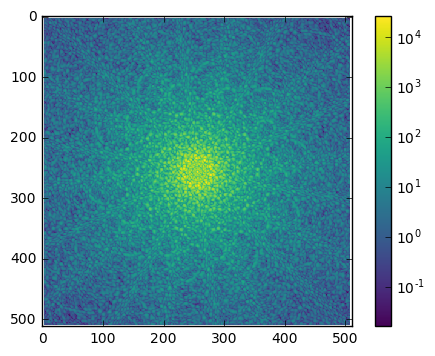

Error for offsets (2.92e-01,2.92e-01),(7.54e-04,7.54e-04) and fluxes 7.48e-02,1.06e+00: 27852.0% baseline 


6858319935.618021

In [19]:
# How do things look now?
model_err(opt.x, view=True)

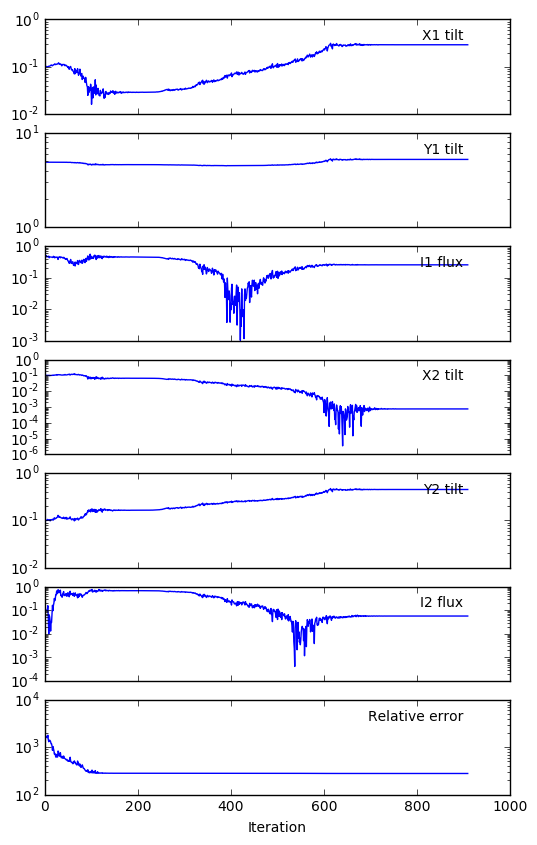

In [28]:
#Visualise the space explored by the optimiser
import matplotlib.pyplot as plt
import math

(I,X1,Y1,F1,X2,Y2,F2,E) = zip(*[(i,dx1-0.,dy1-5.,df1 - 1./3.,dx2-0.,dy2-0.,df2 - 1.,e/min_err) for i,((dx1,dy1,df1,dx2,dy2,df2),e) in enumerate(errors)])

f, axes = plt.subplots(7, sharex=True,figsize=(6,10))
labels = ['X1 tilt','Y1 tilt','I1 flux','X2 tilt','Y2 tilt','I2 flux','Relative error']
for i,V in enumerate([X1,Y1,F1,X2,Y2,F2,E]):
    axes[i].plot(I, np.abs(V))
    axes[i].text(.9,.9,labels[i],
            horizontalalignment='right', verticalalignment='top',
            transform=axes[i].transAxes)
    axes[i].locator_params(axis='y', nbins=6)
    axes[i].set_yscale('log')
axes[6].set_xlabel('Iteration')
plt.show()